In [ ]:
from src.models.vae import VAE
from src.trainer import CLEARVAETrainer
from src.utils.display_utils import interpolate_latent

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=False)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [4]:
from src.utils.data_utils import StyledMNISTGenerator, StyledMNIST

In [5]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


In [6]:
np.random.seed(101)
torch.manual_seed(101)

In [7]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


In [8]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:16<00:00, 3696.64item/s]


### CLEAR as example

In [ ]:
Z_DIM = 16
TEMP = 2
ALPHA = 100
PS = True

vae = VAE(total_z_dim=Z_DIM).to(device)
train_loader = DataLoader(train, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid, batch_size=256, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "ps": PS},
    verbose_period=5,
    device=device,
)

In [10]:
trainer.fit(41, train_loader, valid_loader)

val-epoch 0: 100%|██████████| 40/40 [00:00<00:00, 52.39it/s] 


val_recontr_loss=60.398, val_kl_c=8.956, val_kl_s=15.244, val_c_loss=1.943, val_s_loss=0.106
gMIG: 0.216; mse: 60.398


val-epoch 5: 100%|██████████| 40/40 [00:00<00:00, 157.08it/s]


val_recontr_loss=31.652, val_kl_c=10.934, val_kl_s=16.530, val_c_loss=1.900, val_s_loss=0.106
gMIG: 0.291; mse: 31.652


val-epoch 10: 100%|██████████| 40/40 [00:00<00:00, 148.77it/s]


val_recontr_loss=24.909, val_kl_c=11.224, val_kl_s=17.279, val_c_loss=1.887, val_s_loss=0.106
gMIG: 0.302; mse: 24.909


val-epoch 15: 100%|██████████| 40/40 [00:00<00:00, 160.16it/s]


val_recontr_loss=22.077, val_kl_c=12.221, val_kl_s=17.583, val_c_loss=1.882, val_s_loss=0.106
gMIG: 0.321; mse: 22.077


val-epoch 20: 100%|██████████| 40/40 [00:00<00:00, 141.08it/s]


val_recontr_loss=20.590, val_kl_c=12.916, val_kl_s=18.038, val_c_loss=1.880, val_s_loss=0.106
gMIG: 0.327; mse: 20.59


val-epoch 25: 100%|██████████| 40/40 [00:00<00:00, 160.07it/s]


val_recontr_loss=19.470, val_kl_c=13.255, val_kl_s=18.190, val_c_loss=1.880, val_s_loss=0.106
gMIG: 0.325; mse: 19.47


val-epoch 30: 100%|██████████| 40/40 [00:00<00:00, 170.09it/s]


val_recontr_loss=18.702, val_kl_c=13.958, val_kl_s=18.583, val_c_loss=1.877, val_s_loss=0.106
gMIG: 0.336; mse: 18.702


val-epoch 35: 100%|██████████| 40/40 [00:00<00:00, 152.41it/s]


val_recontr_loss=18.281, val_kl_c=14.549, val_kl_s=18.989, val_c_loss=1.877, val_s_loss=0.106
gMIG: 0.339; mse: 18.281


val-epoch 40: 100%|██████████| 40/40 [00:00<00:00, 159.45it/s]


val_recontr_loss=17.801, val_kl_c=14.464, val_kl_s=18.961, val_c_loss=1.877, val_s_loss=0.106
gMIG: 0.337; mse: 17.801


In [31]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)

In [32]:
torch.random.manual_seed(0)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

In [36]:
from expr.visual_utils import feature_swapping_plot

In [ ]:
# creates dictionaries to store the indices of unique elements in c and s, 
# and then collects specific indices from s_idx_dict into the img_idx list.
c_idx_dict = {}
for _c in c.unique():
    c_idx_dict[_c.item()] = torch.where(c == _c)[0]
s_idx_dict = {}
for _s in s.unique():
    s_idx_dict[_s.item()] = torch.where(s == _s)[0]
img_idx = [] 
for _idx in s_idx_dict.values():
    img_idx.append(_idx[1].item())
    img_idx.append(_idx[-1].item())    

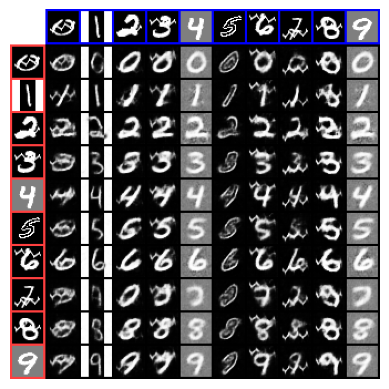

In [ ]:
# choose the 5-th image in each class
img_idx = [_idx[5].item() for _idx in c_idx_dict.values()]

with torch.no_grad():
    z_c, z_s = z[img_idx, :int(Z_DIM / 2)], z[img_idx, int(Z_DIM / 2):]
    n = z_c.size(0)
    paired_z = torch.cat((z_c[:, None, :].repeat(1, n, 1),
                        z_s[None, :, :].repeat(n, 1, 1)), dim=-1).view(-1, Z_DIM)
    paired_z.shape

feature_swapping_plot(z_c, z_s, X[img_idx], vae)

In [38]:
from expr.visual_utils import interpolation_plot

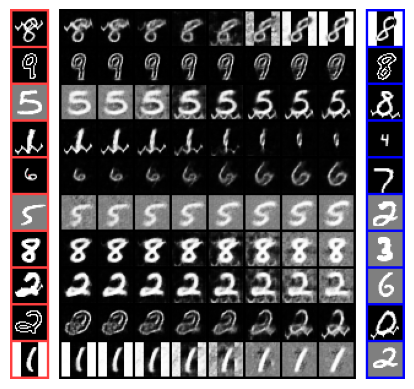

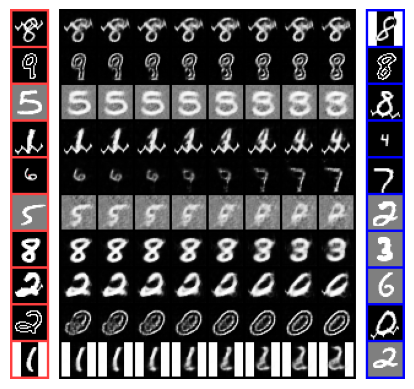

In [39]:
interpolation_plot(X, z, vae, int(Z_DIM / 2), inter_steps=8)